# Operationalizer

**Variables to be operationalized**
- price in USD
- category variable
- ARF (market entry strategy) 
- market exit (deletion of account)
- ARM (time series)
- selling price adjustment (time series)
- proportion of negative feedbacks (time series)


In [142]:
import pandas as pd
import numpy as np

# plotting setup
import matplotlib.pyplot as plt
import matplotlib as mpl 

mpl.rcParams['figure.dpi']= 400
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import nbextensions
from datetime import datetime
import os
import swifter
import seaborn as sns

## Silkroad2 Item Information

In [143]:
folder = '/Volumes/Extreme SSD/data/final/silkroad2'
file   = 'items.pickle'

df = pd.read_pickle(os.path.join(folder, file))

In [144]:
df['stime_str'] = pd.to_datetime(df.stime_str, format = "%Y-%m-%d").astype('datetime64')

In [145]:
t_max = df['rtime_dt'].max()
t_min = df['rtime_dt'].min()

df.sample(5)

vendor         stime            stime_dt  stime_str  rating  \
104973          Incoming  1.402430e+09 2014-06-10 19:55:48 2014-03-03       5   
151635   lance.armstr0ng  1.402430e+09 2014-06-10 19:58:29 2014-03-10       5   
1311555     jamesbrown95  1.415146e+09 2014-11-05 00:01:46 2014-11-05       5   
342096        BlueViking  1.402431e+09 2014-06-10 20:07:50 2014-05-10       5   
781167    bodyinaction83  1.409214e+09 2014-08-28 08:25:42 2014-08-30       5   

                                                  feedback  \
104973                                 Superb!! Thank you!   
151635               100% top fast shipping trusted vendor   
1311555  JamesBrown is one of the rare true professiona...   
342096   Quick ship. Good stealth. Quality product. Ful...   
781167                         FE, always trusted this guy   

                                                      item     price  \
104973          FTV Girls 1 Month account (normally $29.95  0.025534   
151635   5g purest MDMA from the Lab, still pasty, very...  0.350536   
1311555                1 Gram of Candy Jack honeycomb wax   0.158980   
342096                         10x 125ug Czech Silver Xtal  0.148953   
781167      Clenbuterol Sopharma (original) 0.02mg/ 50tabs  0.050278   

         freshness         rtime            rtime_dt       location  \
104973          87  1.394913e+09 2014-03-15 19:55:48  United States   
151635          51  1.398024e+09 2014-04-20 19:58:29        Germany   
1311555         49  1.410912e+09 2014-09-17 00:01:46  United States   
342096           0  1.402431e+09 2014-06-10 20:07:50  United States   
781167         212  1.390898e+09 2014-01-28 08:25:42     Undeclared   

                   area  
104973        Worldwide  
151635   European Union  
1311555       Worldwide  
342096        Worldwide  
781167        Worldwide

## Bitcoin Conversion information

In [87]:
# scrape Bitcoin data
url = "https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130429&end=20200212"

bitcoin_data = pd.read_html(url)[2]
bitcoin_data.columns =  map(str.lower, bitcoin_data.columns)

In [88]:
bitcoin_data = bitcoin_data[['date', 'open*', 'high', 'low', 'close**']]\
    .assign(date = pd.to_datetime(bitcoin_data['date']),
            mean = bitcoin_data[['high', 'low']].mean(axis=1))\
    .sort_values('date')\
    .reset_index(drop = True)

# define observation period
observation_period = (bitcoin_data['date'] > t_min)\
                      & (bitcoin_data['date'] < t_max)

max_bit = bitcoin_data[observation_period]['mean'].max()
min_bit = bitcoin_data[observation_period]['mean'].min()

In [89]:
bitcoin_data

date     open*      high       low   close**       mean
0    2013-04-29    134.44    147.49    134.00    144.54    140.745
1    2013-04-30    144.00    146.93    134.05    139.00    140.490
2    2013-05-01    139.00    139.89    107.72    116.99    123.805
3    2013-05-02    116.38    125.60     92.28    105.21    108.940
4    2013-05-03    106.25    108.13     79.10     97.75     93.615
...         ...       ...       ...       ...       ...        ...
2476 2020-02-08   9793.07   9876.75   9678.91   9865.12   9777.830
2477 2020-02-09   9863.89  10129.44   9850.39  10116.67   9989.915
2478 2020-02-10  10115.56  10165.77   9784.56   9856.61   9975.165
2479 2020-02-11   9855.89  10210.05   9729.33  10208.24   9969.690
2480 2020-02-12  10202.39  10393.61  10202.39  10326.05  10298.000

[2481 rows x 6 columns]

### Fluctiations in bitcoin price

Bitcoin infamously known for its price flucuations. Although the window of observation of this study is way beyond the "bitcoin bubble" occured, there were considerable changes in bitcoin prices overtime.  {{max_bit}}

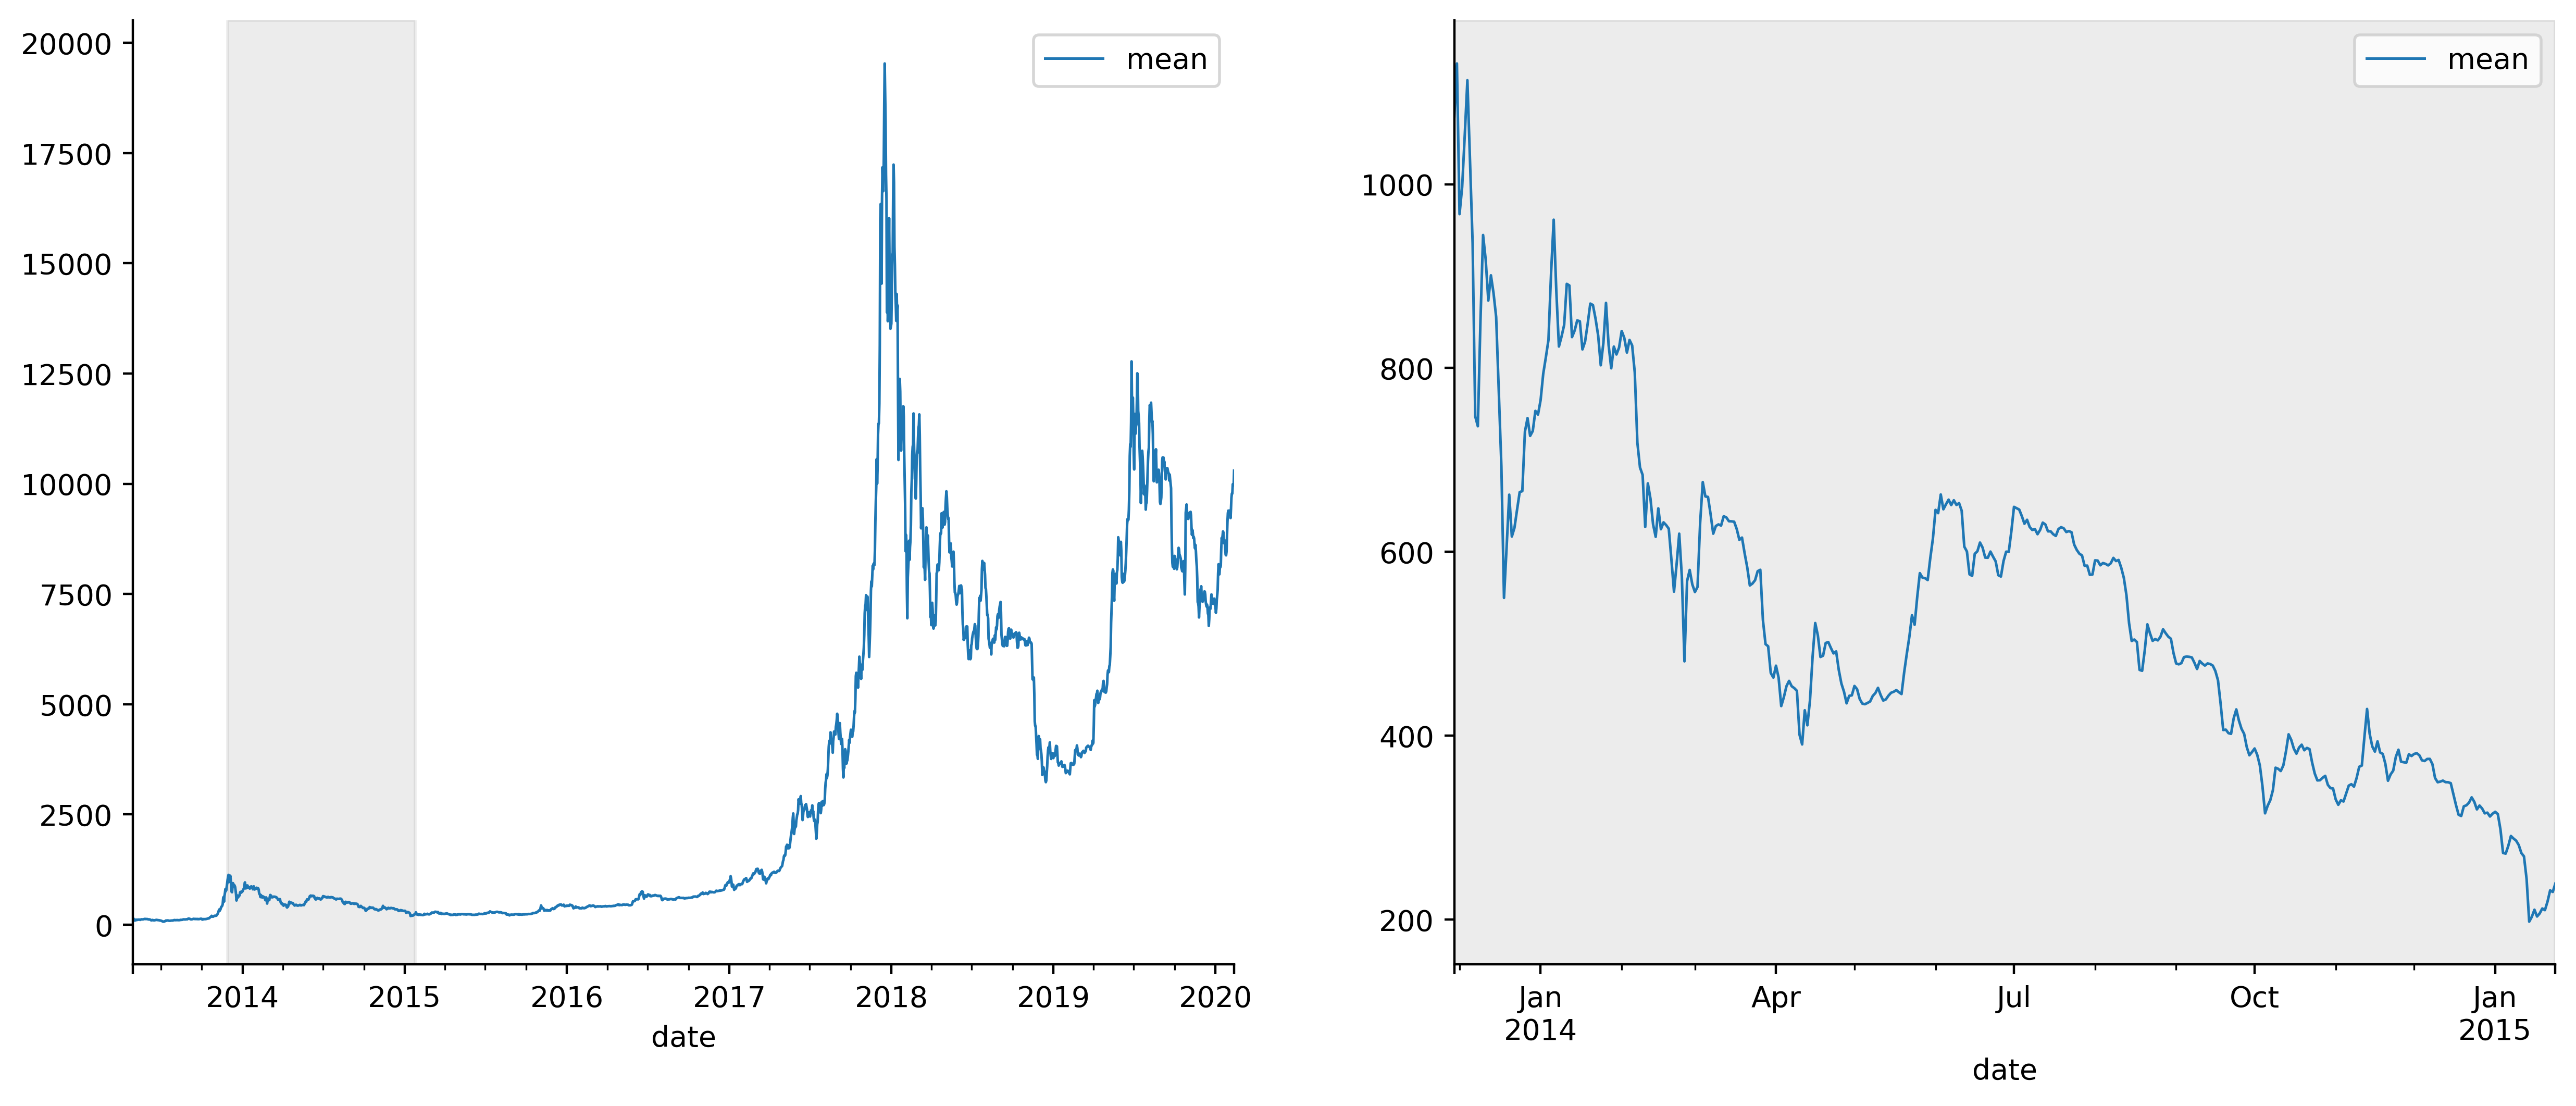

In [90]:
# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 6))

# all time
bitcoin_data.plot(
    linewidth = .9,
    x = 'date',
    y = 'mean',
    ax = ax1
)

ax1.axvspan(t_min, t_max, color='grey', alpha=0.15)

# time window of observations
bitcoin_data.loc[observation_period].plot(
    linewidth = .9,
    x = 'date',
    y = 'mean',
    ax = ax2
)

ax2.axvspan(t_min, t_max, color='grey', alpha=0.15)

plt.show()

## Converting bitcoin to USD

To make the prices comparable over time points we convert te bitcoin prices to USD. 

In [91]:
def get_bitcoin_price(date):
    if not pd.isnull(date):
        date = date.strftime("%Y-%m-%d")
        price = bitcoin_data[bitcoin_data['date'] == date]\
            .loc[:,'mean']\
            .values[0]
    else:
        price = np.nan
    
    return price

# the swifter packages applies mutations more efficiently
df['price_usd'] = df.swifter.apply(lambda row: row['price'] * get_bitcoin_price(row.rtime_dt), axis = 1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/_tqdm.py:603: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


24878


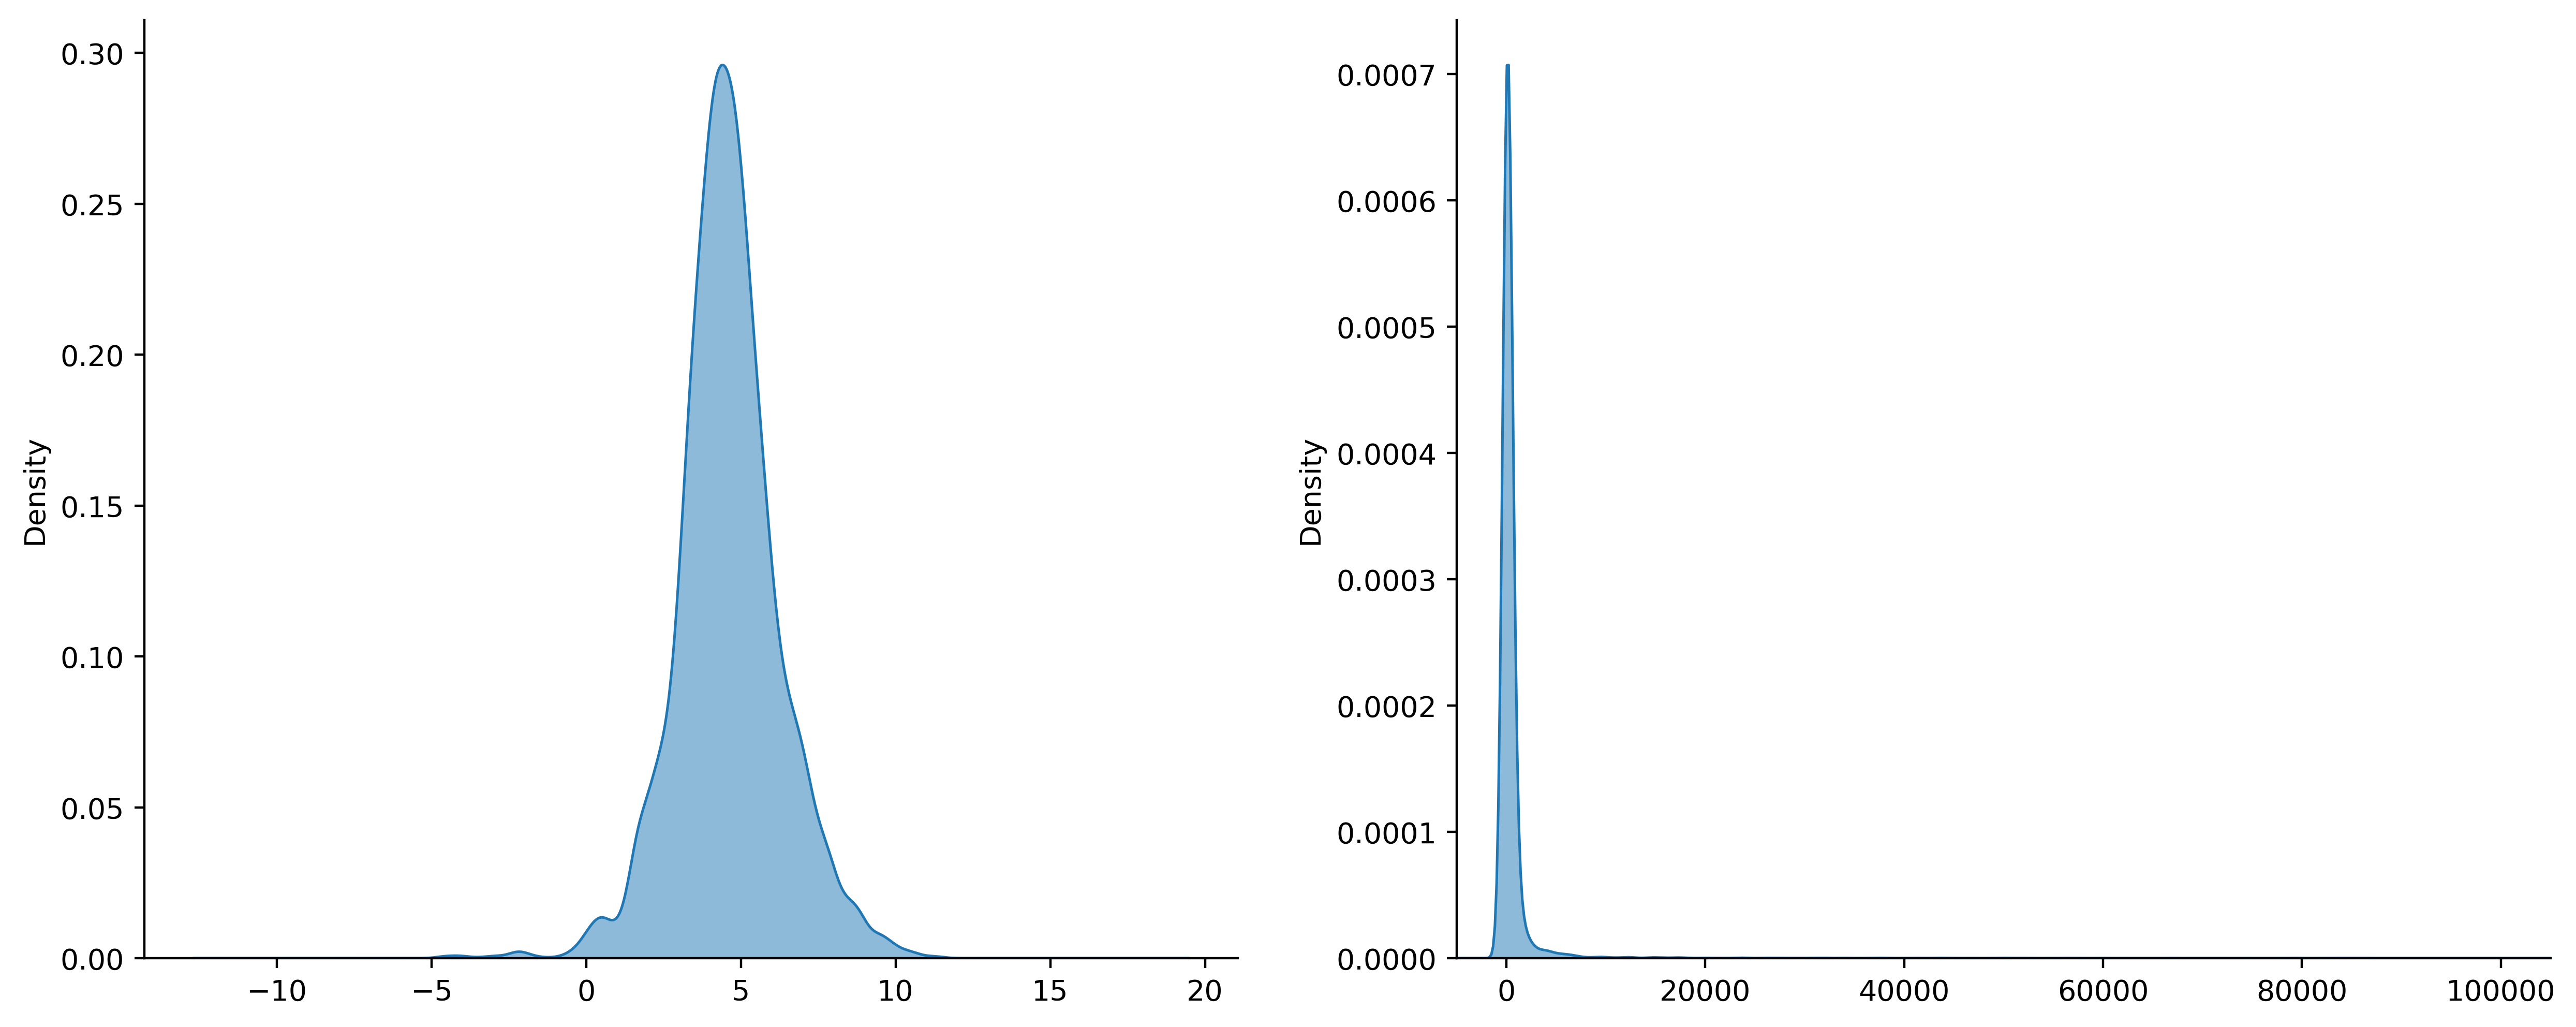

In [92]:
valid_range = (~df['price_usd'].isin([np.nan, np.inf, -np.inf]))\
            & (df['price_usd'] < 100000)\
            & (df['price_usd'] > 0.001)

# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 6))

# plot log transformed price (left)
df['price_usd'][valid_range]\
    .sample(10000)\
    .transform(np.log)\
    .plot.kde(linewidth = .9, ax = ax1)

# fill density plot (left)
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)

# plot not transformed price (right)
df['price_usd'][valid_range]\
    .sample(10000)\
    .plot.kde(linewidth = .9, ax = ax2)

# fill density plot (right)
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)
ax2.set_xlim([-5000, 105000])

# asses attriation due to invalid values
k_org = len(df['price_usd'][~df['price_usd'].isin([np.nan, np.inf, -np.inf])])
k_val = len(df['price_usd'][valid_range])
print(k_org - k_val)

plt.show()

The prices of products on *silkroad2* are extremely right skewed. Top tier prices range in USD +100,000. `log`-transformation helps to normalized selling prices considerably. Prices higher than USD 100,000 are considered outliers and are therefore excluded from the data. There by 24497 observations were coded as missing, which can be explained by: 
- missingness on the price variable
- `inf` value on the price value
- missingness on data value

In [93]:
# invalid cases are masked
df['price_usd'] = df['price_usd'].mask(~valid_range)

# Rating Time

Rating time (`rtime`) is an instrumental variable to our analysis. Therefore the reliably and quality of this variable is assessed. In our sample a few feedback postings were observed that fall outside of the observation period. These values are backcensored the quality of the data.

In [146]:
print(df[['stime_str', 'rtime_dt']].describe())

# print number of cases outside of observation period
print("\nbackcensored values because of invalid timestamp: ", 
      sum(((df.rtime_dt - df.stime_str.max()).dt.days > 0) == True))

df['rtime_dt'] = df.rtime_dt.mask((df.rtime_dt - df.stime_str.max()).dt.days > 0)

                  stime_str             rtime_dt
count               1362588              1362428
unique                   57               451371
top     2014-08-27 00:00:00  2015-01-23 17:01:14
freq                 107933                  405
first   2013-12-20 00:00:00  2013-11-28 00:01:29
last    2014-11-06 00:00:00  2015-01-24 17:01:31

backcensored values because of invalid timestamp:  16231


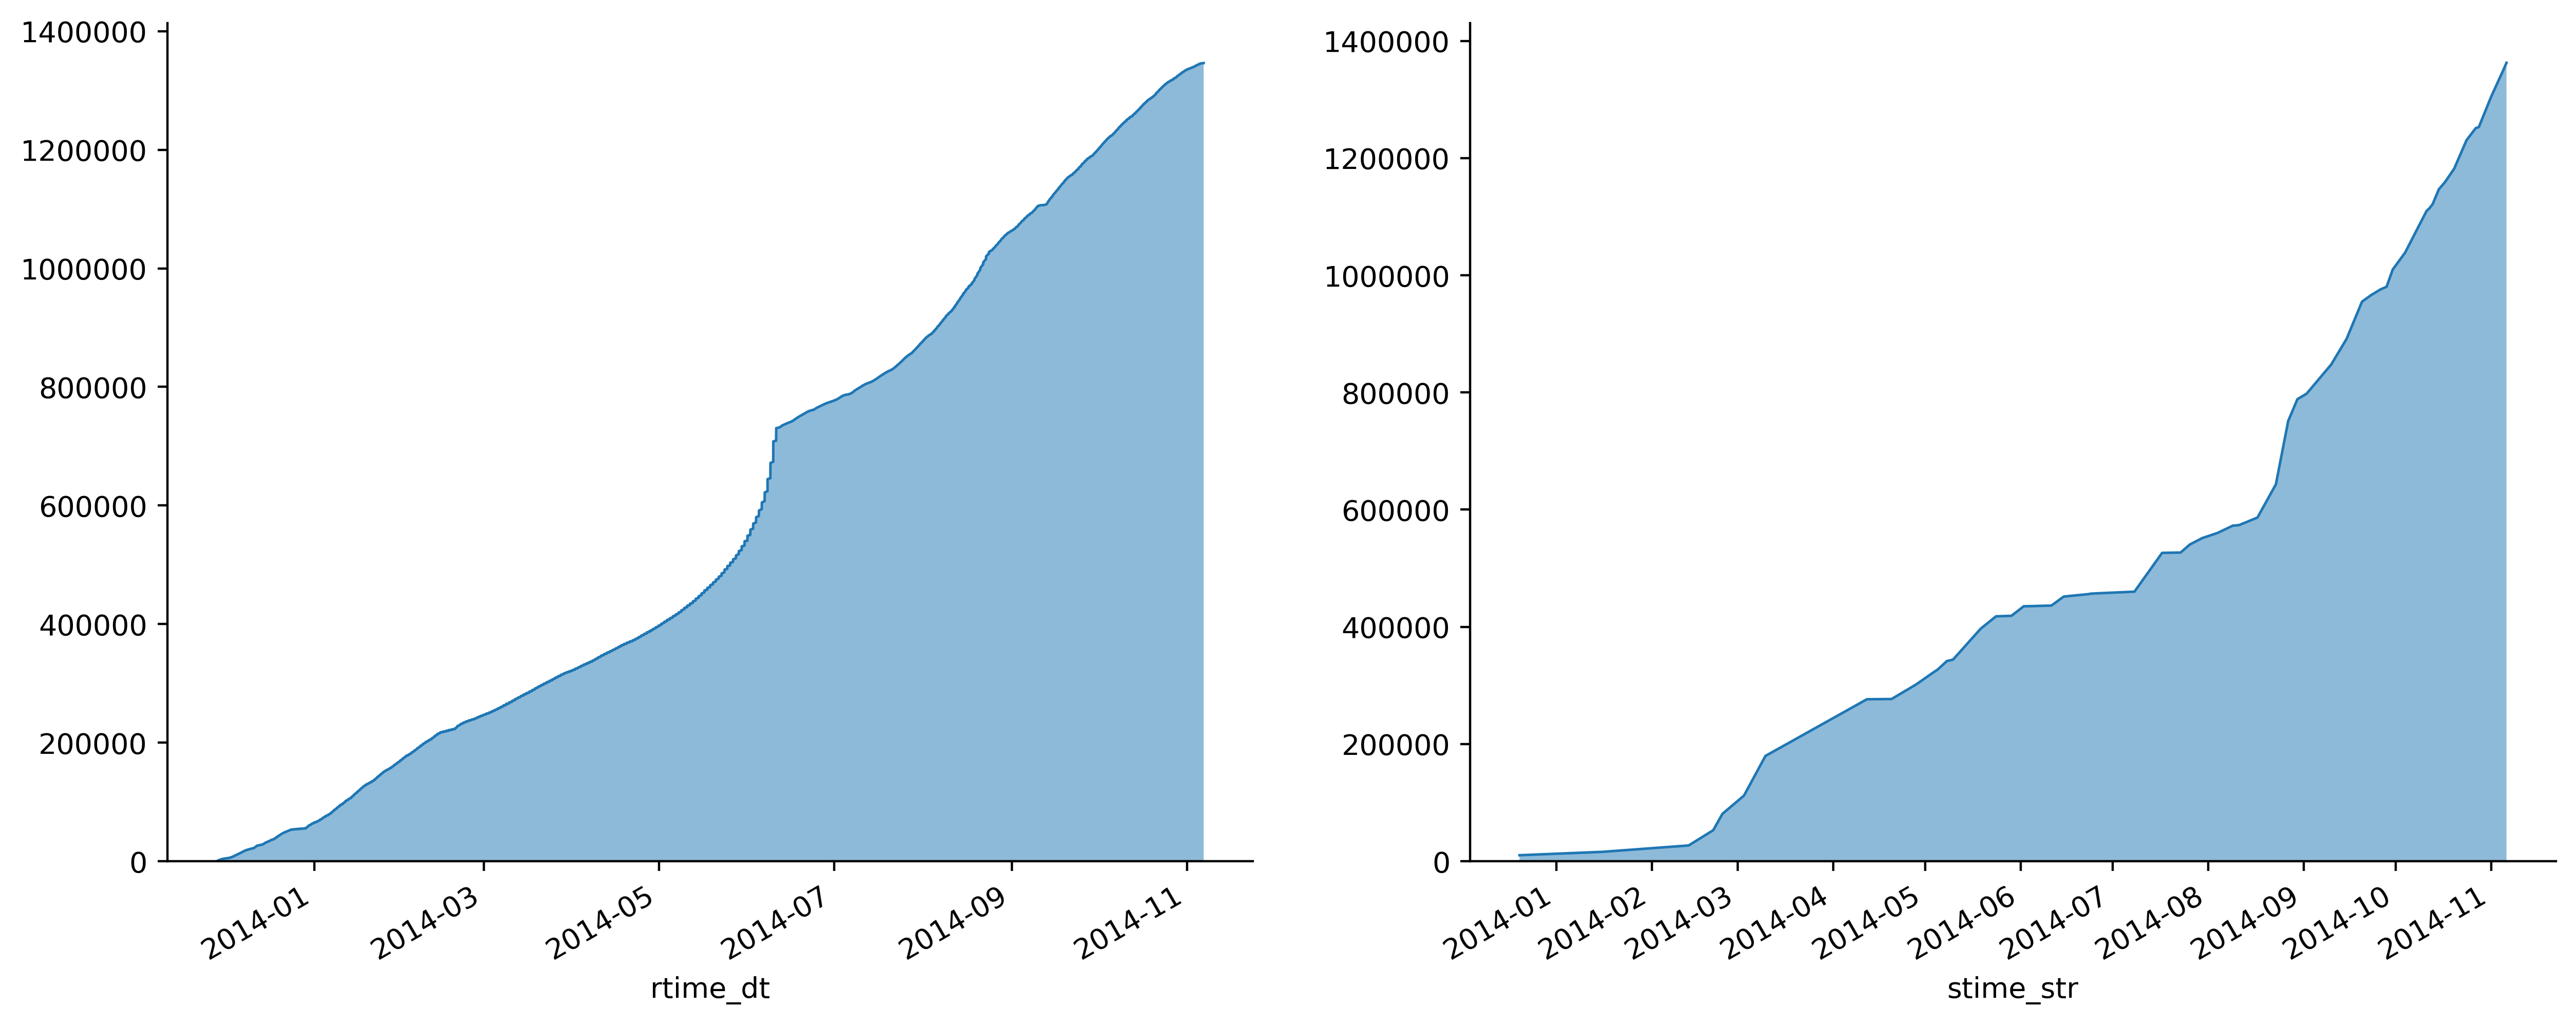

In [147]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 6))

#make cum_dist plot rating time
df\
    .groupby('rtime_dt')['vendor']\
    .count()\
    .cumsum()\
    .plot(ax = ax1, linewidth = .9)
ax1.set_ylim(bottom = 0)

#fill cum_dist plot
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)


# make cum_dist plot scrape time
df\
    .groupby('stime_str')['vendor']\
    .count()\
    .cumsum()\
    .plot(ax = ax2, linewidth = .9)
ax2.set_ylim(bottom = 0)

#fill cum_dist plot
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)

plt.show()

The plots above show the cumulative distribution of sample size by rating time (left: `rtime`) and scrape time (right: `stime`). 

#### Cumulative distribution of feedback postings
The left subplot show that the feedbacks posted in our sample are posted gradually over time. This reflects a natural growth distribution of feedback postings in the collected sample. This indicates that the scraping process of the data has proceeded quite reliably. 

#### Cumulative sample size make up per scrape
On the right subplot shows an increasing growth of sample size, which is an inherent characteristic of scraped data. Scrapes at later time points might collect data points that were overlooked in previous scrapes. 

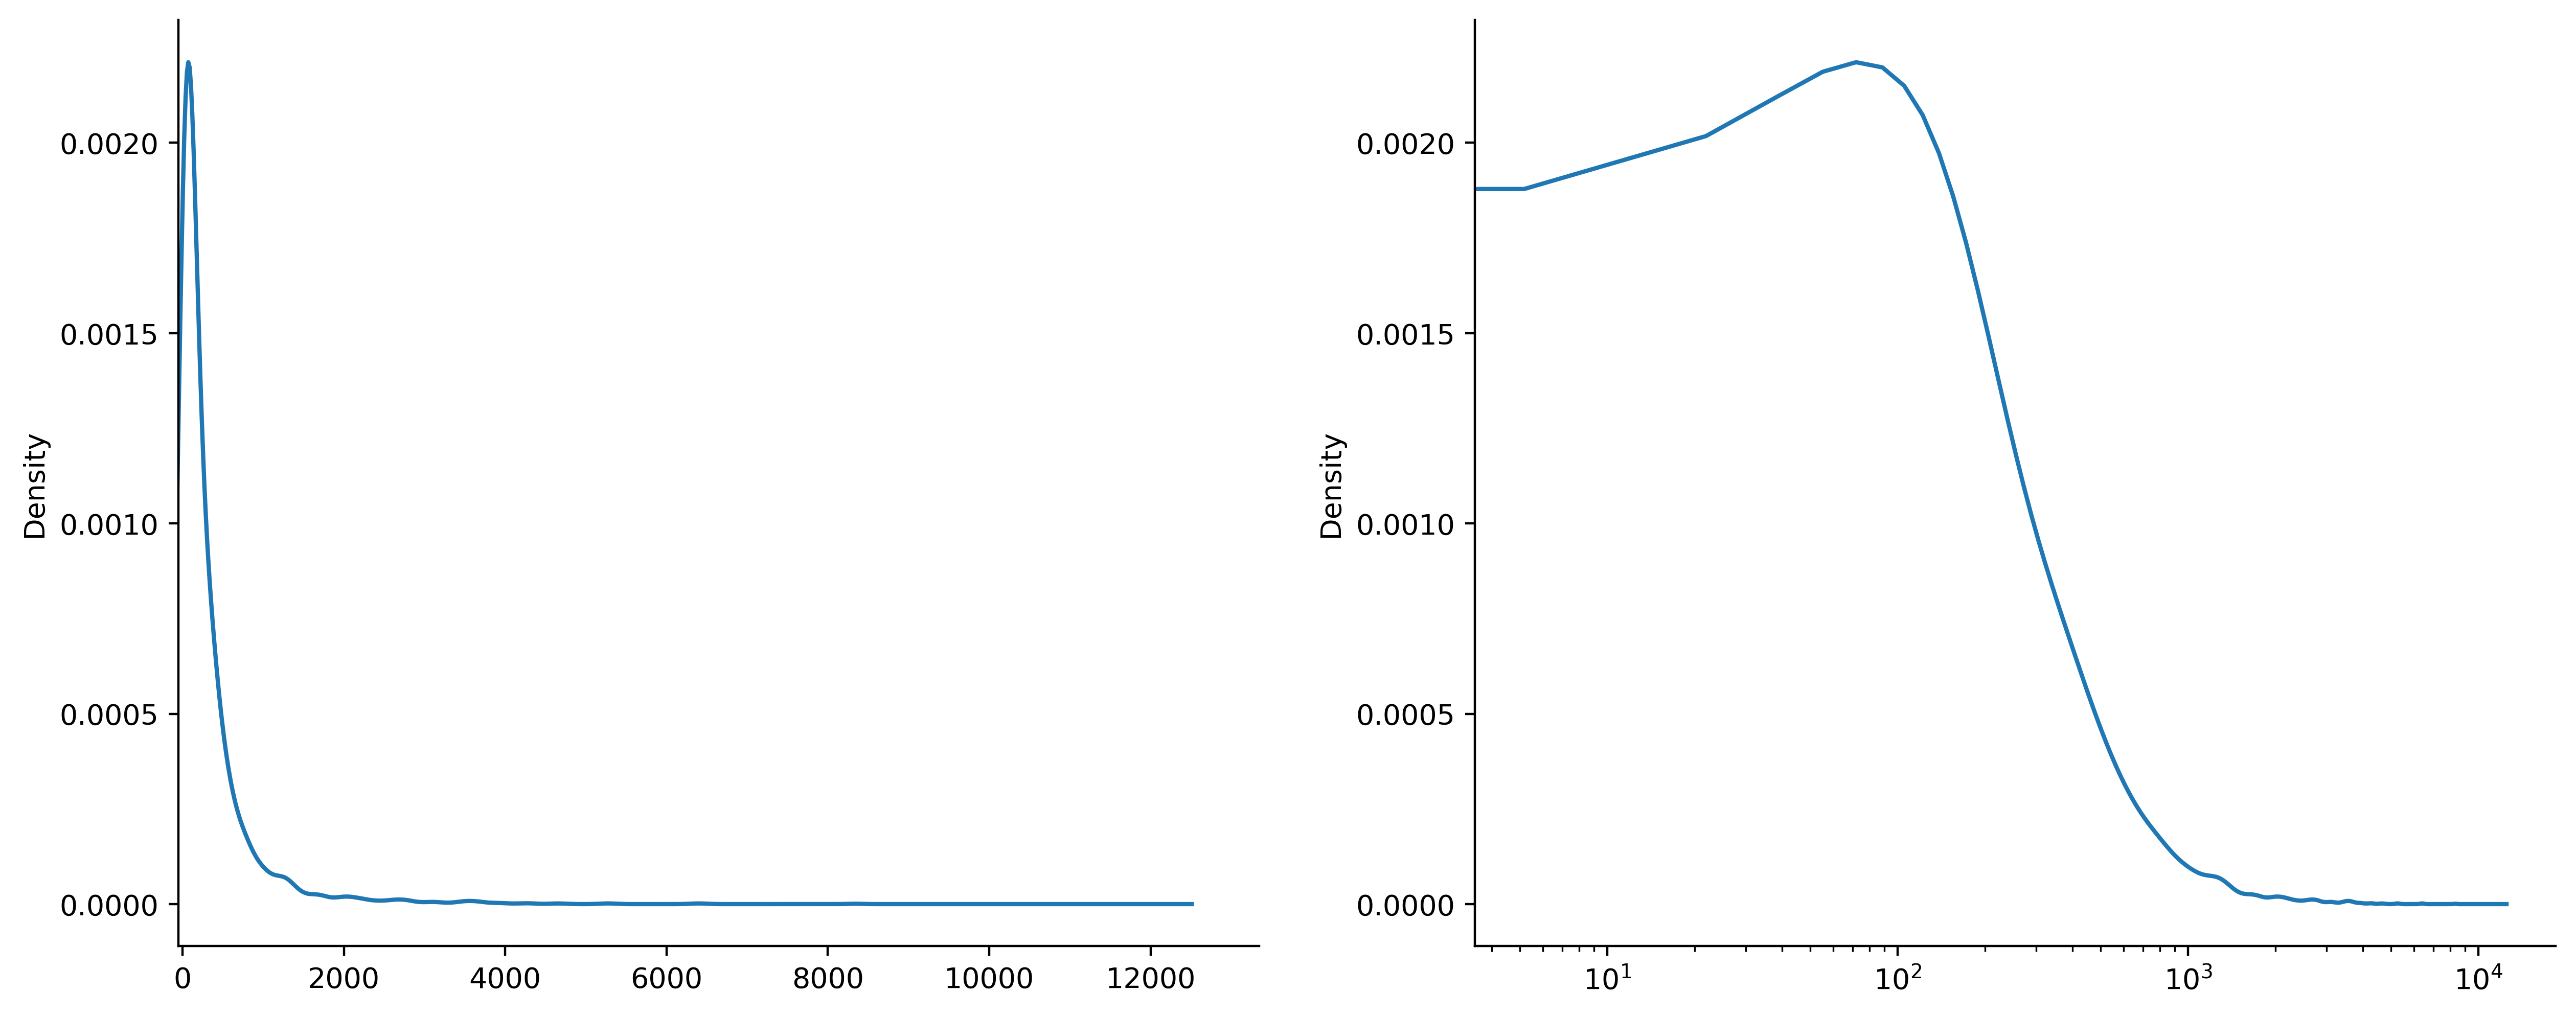

In [148]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

df['vendor'].value_counts().plot.kde(ax = ax1)
ax1.set_xlim(left = -50)

df['vendor'].value_counts().plot.kde(ax = ax2)
ax2.set_xscale('log')

plt.show()

# Time of feedback posting

In [159]:
df['t'] = pd.to_numeric(df.groupby('vendor')['rtime_dt']\
    .transform(lambda x: x - x.min())\
    .dt.days, downcast = 'integer', errors = 'coerce')

df['count'] = df.groupby(['vendor']).cumcount()
df['cum_count'] = df.groupby('vendor')['vendor'].transform(np.size)

In [172]:
df = df.sort_values('t')
df.sample(5)

vendor         stime            stime_dt  stime_str  rating  \
380815              only  1.402431e+09 2014-06-10 20:09:31 2014-05-19       5   
383772      carlos lopez  1.402431e+09 2014-06-10 20:09:38 2014-05-19       5   
584646         DrawkwarD  1.408147e+09 2014-08-16 00:00:58 2014-08-17       5   
1236899  everythingman85  1.414294e+09 2014-10-26 03:20:57 2014-10-27       5   
478448         levelhead  1.408831e+09 2014-08-23 21:54:39 2014-07-17       5   

                                                  feedback  \
380815   New Biggest Marketplace: http://bigshopcucn64a...   
383772                      Fast delivery and smells good!   
584646                               worked so far, thanks   
1236899              Got it! Everything perfect! Thanks!!!   
478448                            Can't wait to try these!   

                                                      item     price  \
380815               Camel Blue (10 packs x 20 cigarettes)  0.095653   
383772                                    Durban Poison 1g  0.040966   
584646               Hulu Plus Account + Lifetime Warranty  0.009988   
1236899                           100g GHB (Na-GHB) Powder  0.458463   
478448   100 Grams Of Crystal Ethylphenidate - 99.6% Pure!  1.379981   

         freshness         rtime            rtime_dt        location  \
380815           0  1.402431e+09 2014-06-10 20:09:31      Undeclared   
383772           9  1.401653e+09 2014-06-01 20:09:38      Undeclared   
584646           1  1.408061e+09 2014-08-15 00:00:58      Undeclared   
1236899        297  1.388633e+09 2014-01-02 03:20:57      Undeclared   
478448          16  1.407448e+09 2014-08-07 21:54:39  United Kingdom   

               area      t  count  cum_count  
380815    Worldwide  193.0   1523       1839  
383772    Worldwide  185.0    864       2128  
584646   Undeclared  239.0   5766       6429  
1236899   Worldwide   34.0     49        327  
478448    Worldwide   76.0    466        643

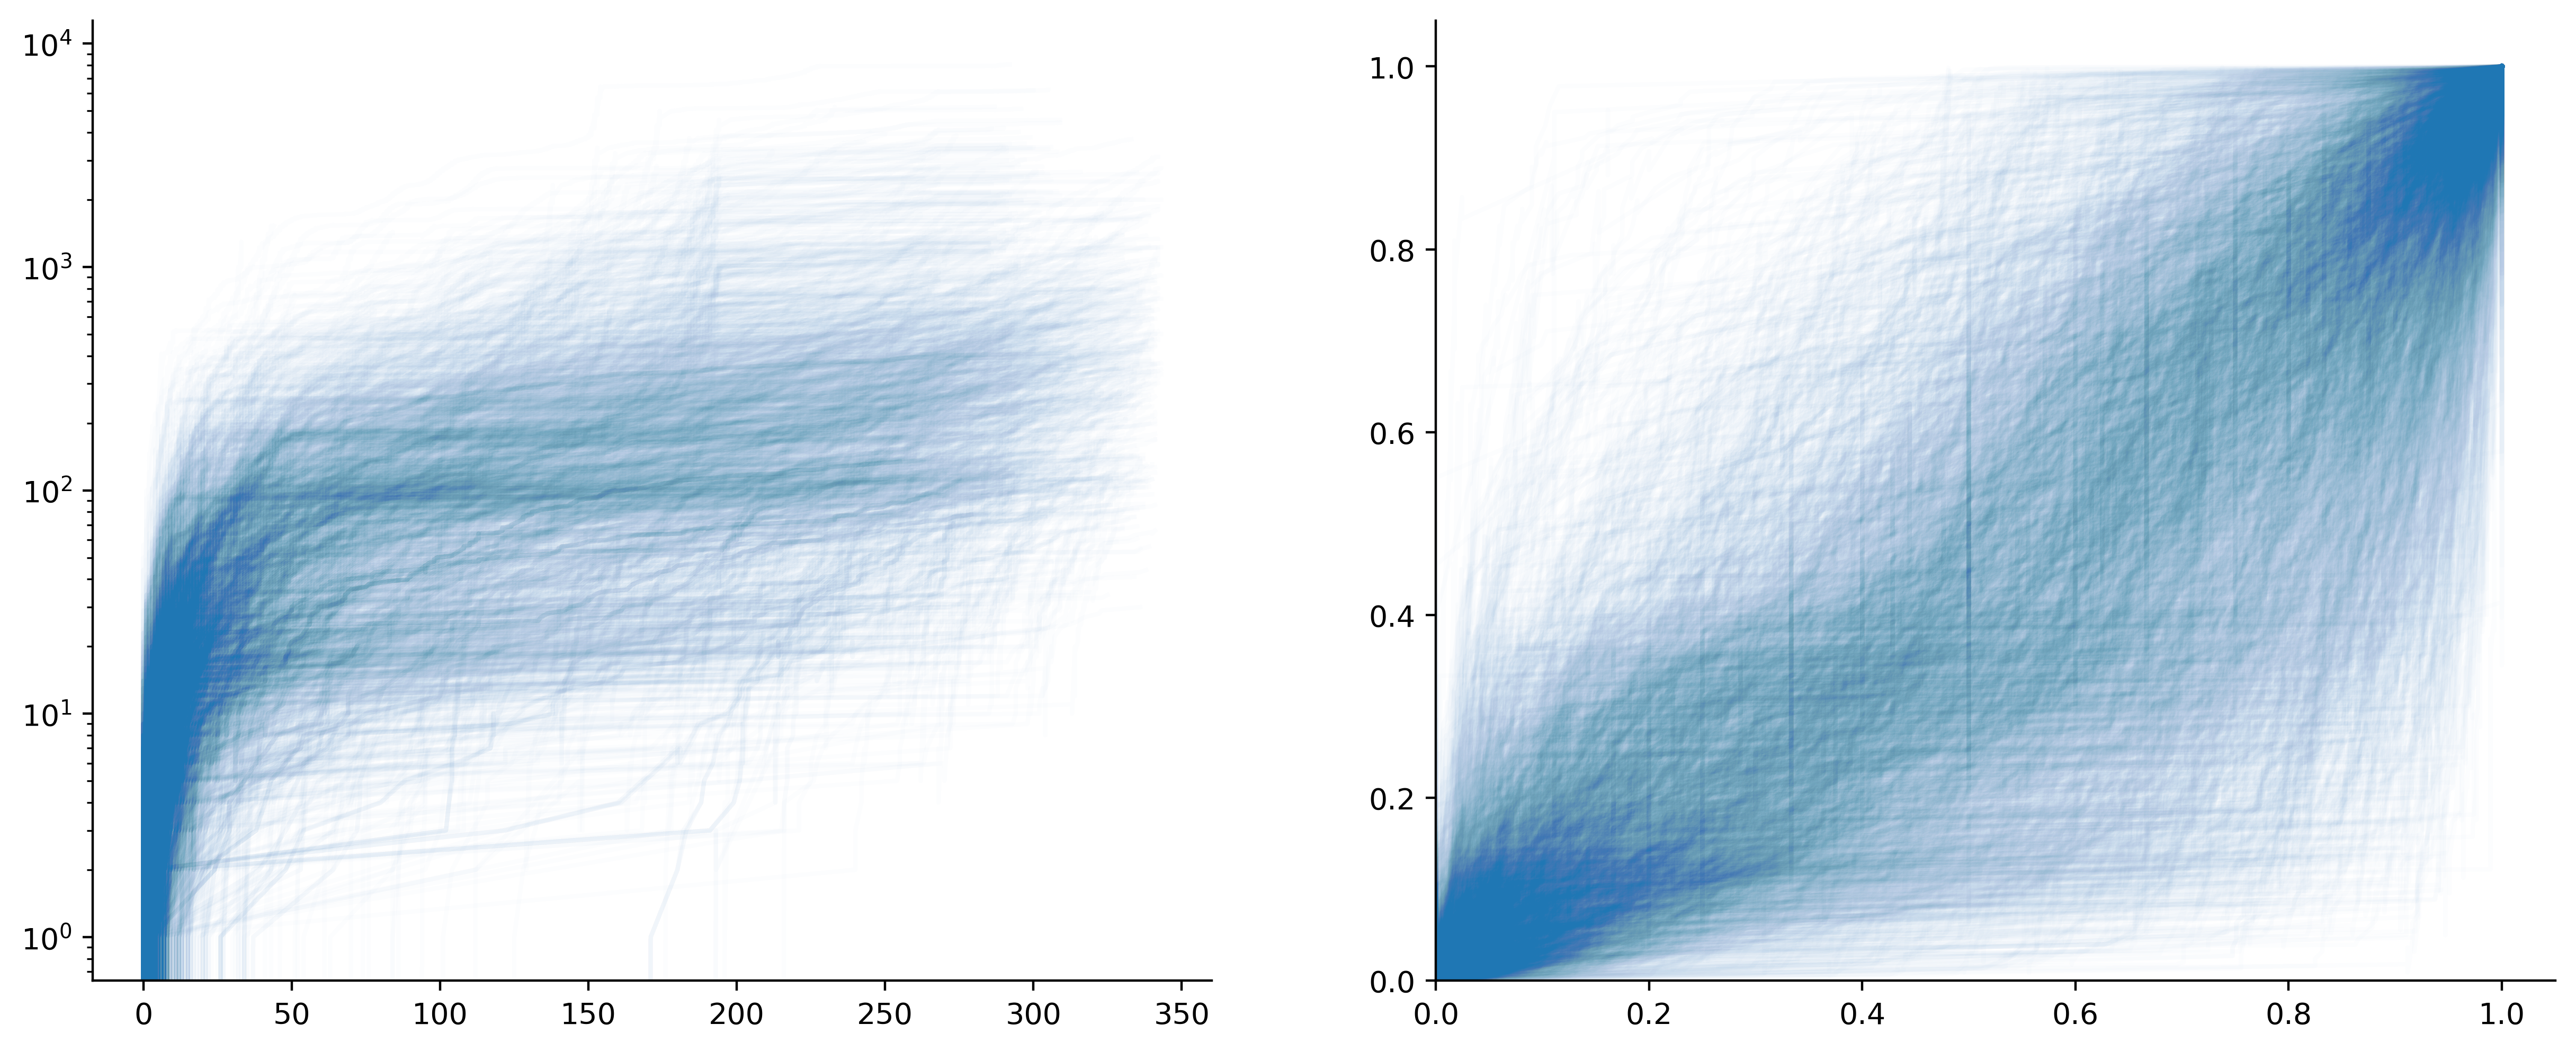

In [164]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# getting sellers that have had sufficient number of sales
df_ = df[df['cum_count'] >= 20]
vendors = df_['vendor'].unique().tolist()

# iterative plotting for sales trajectory of cryptosellers
for vendor in vendors:
    v = df_[df_['vendor'] == vendor][['count', 't']].dropna()
    y = v['count'].astype(int)
    x = v['t'].astype(int)
    
    ax1.plot(x, y, alpha = .01, c = '#1f77b4')
    ax1.set_yscale('log')
    
    y = y / v['count'].max().astype(int)
    x = x / v['t'].max().astype(int)
    
    ax2.plot(x, y, alpha = .01, c = '#1f77b4')
    ax2.set_xlim(left = 0)


# display plot
plt.show()

In [ ]:
def f(x):
    x['diff'] = x['t']-x['t'].iloc[0]
    return x

diff = df.groupby('vendor')\
    .apply(f)\
    .groupby('vendor')\
    .groupby('rtime_dt')['diff']\
    .mean().nth(1)

In [193]:
diff

t
0.0        0.0
1.0        1.0
2.0        2.0
3.0        3.0
4.0        4.0
5.0        5.0
6.0        6.0
7.0        7.0
8.0        8.0
9.0        9.0
10.0      10.0
11.0      11.0
12.0      12.0
13.0      13.0
14.0      14.0
15.0      15.0
16.0      16.0
17.0      17.0
18.0      18.0
19.0      19.0
20.0      20.0
21.0      21.0
22.0      22.0
23.0      23.0
25.0      25.0
26.0      26.0
27.0      27.0
28.0      28.0
29.0      29.0
30.0      30.0
32.0      32.0
33.0      33.0
34.0      34.0
35.0      35.0
37.0      37.0
40.0      40.0
41.0      41.0
51.0      51.0
54.0      54.0
61.0      61.0
63.0      63.0
64.0      64.0
74.0      74.0
84.0      84.0
96.0      96.0
101.0    101.0
106.0    106.0
107.0    107.0
125.0    125.0
151.0    151.0
171.0    171.0
176.0    176.0
196.0    196.0
Name: diff, dtype: float64